# imports

In [1]:
import pandas as pd
import numpy as np; np.random.seed(0)

import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns; sns.set(font='Malgun Gothic')
import warnings; warnings.filterwarnings(action='ignore')

import lightgbm as lgb

# read

In [2]:
total = pd.read_csv('./input/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
test  = pd.read_csv('./input/test.csv')
sub   = pd.read_csv('./input/sample_submission.csv')
temp  = pd.read_csv('./input/STCS_우리나라기후평년값_DD_20211026151605.csv') # 2001 ~ 2010년 일별 기후평년값

# https://data.kma.go.kr/climate/average30Years/selectAverage30YearsKoreaList.do?pgmNo=188

In [3]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB


In [4]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   일자|시간|구분  15120 non-null  object
dtypes: object(1)
memory usage: 118.2+ KB


In [6]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [7]:
test['연월일'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간']  = test['일자|시간|구분'].str.split(' ').str[1].astype('int')
test['구분']  = test['일자|시간|구분'].str.split(' ').str[2]

test.drop('일자|시간|구분', axis=1, inplace=True)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연월일     15120 non-null  object
 1   시간      15120 non-null  int32 
 2   구분      15120 non-null  object
dtypes: int32(1), object(2)
memory usage: 295.4+ KB


In [9]:
test.head()

,연월일,시간,구분
0,2019-01-01,1,A
1,2019-01-01,2,A
2,2019-01-01,3,A
3,2019-01-01,4,A
4,2019-01-01,5,A


# temp : 일별평년값

In [10]:
temp.head()

,지점명,지점번호,일시,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm),습도(%),일조시간(hr),전운량(1/10),소형증발량(mm),현지기압(hPa),해면기압(hPa),평균풍속(m/sec)
0,속초,90,01-01,-0.6,3.4,-4.3,0.5,39.8,6.2,NaN,NaN,1017.3,1019.6,NaN
1,철원,95,01-01,-6.6,-0.6,-12.7,0.6,66.5,5.5,NaN,NaN,1003.7,1023.6,NaN
2,동두천,98,01-01,-4.9,0.9,-10.1,0.5,60.9,5.5,NaN,NaN,1009.0,1023.5,NaN
3,파주,99,01-01,-5.0,0.8,-10.9,0.2,65.4,5.8,NaN,NaN,1019.9,1023.8,NaN
4,대관령,100,01-01,-7.7,-2.7,-12.6,0.6,65.8,6.6,NaN,NaN,920.7,1020.9,NaN


In [11]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76860 entries, 0 to 76859
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   지점명          76860 non-null  object 
 1   지점번호         76860 non-null  int64  
 2   일시           76860 non-null  object 
 3   평균기온(°C)     76860 non-null  float64
 4   최고기온(°C)     76860 non-null  float64
 5   최저기온(°C)     76860 non-null  float64
 6   강수량(mm)      76860 non-null  float64
 7   습도(%)        28914 non-null  float64
 8   일조시간(hr)     28914 non-null  float64
 9   전운량(1/10)    0 non-null      float64
 10  소형증발량(mm)    0 non-null      float64
 11  현지기압(hPa)    28914 non-null  float64
 12  해면기압(hPa)    28914 non-null  float64
 13  평균풍속(m/sec)  47946 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 8.2+ MB


In [12]:
temp.dropna(axis=1, how='any', inplace=True)

In [13]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76860 entries, 0 to 76859
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   지점명       76860 non-null  object 
 1   지점번호      76860 non-null  int64  
 2   일시        76860 non-null  object 
 3   평균기온(°C)  76860 non-null  float64
 4   최고기온(°C)  76860 non-null  float64
 5   최저기온(°C)  76860 non-null  float64
 6   강수량(mm)   76860 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.1+ MB


In [14]:
temp.head()

,지점명,지점번호,일시,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm)
0,속초,90,01-01,-0.6,3.4,-4.3,0.5
1,철원,95,01-01,-6.6,-0.6,-12.7,0.6
2,동두천,98,01-01,-4.9,0.9,-10.1,0.5
3,파주,99,01-01,-5.0,0.8,-10.9,0.2
4,대관령,100,01-01,-7.7,-2.7,-12.6,0.6


In [15]:
temp['일시'].max(), temp['일시'].min()

('12-31', '01-01')

In [16]:
temp = temp.groupby('일시').mean()
temp.drop('지점번호', axis=1, inplace=True)
temp

,평균기온(°C),최고기온(°C),최저기온(°C),강수량(mm)
일시,,,,
01-01,-1.348095,3.390952,-5.760000,0.444762
01-02,-1.238095,3.580476,-5.614762,0.463333
01-03,-1.255714,3.718095,-5.735238,0.374762
01-04,-1.260000,3.876190,-5.880476,0.401905
01-05,-1.423333,3.754286,-6.000476,0.726190
...,...,...,...,...
12-27,-0.816190,4.194762,-5.228095,0.483810
12-28,-1.304762,3.558571,-5.683333,0.527619
12-29,-1.516190,3.280952,-5.939048,0.608095


# temp pca

In [17]:
from sklearn.decomposition import PCA

temp_pca = PCA(n_components=1)
pca_cols = ['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '강수량(mm)']
temp_pca.fit(temp[pca_cols])

temp_pca.explained_variance_ratio_

array([0.97560316])

In [18]:
temp['temp_pca'] = temp_pca.transform(temp[pca_cols])
temp.drop(pca_cols, axis=1, inplace=True)

In [19]:
temp.head()

,temp_pca
일시,
01-01,25.023228
01-02,24.767818
01-03,24.788009
01-04,24.783260
01-05,24.955461


# merge temp

In [20]:
total['일시'] = total['연월일'].str[5:]
test['일시']  = test['연월일'].str[5:]

In [21]:
total = pd.merge(total, temp, how='left', on='일시')
test  = pd.merge(test, temp, how='left', on='일시')

total.drop('일시', axis=1, inplace=True)
test.drop('일시', axis=1, inplace=True)

# EDA

In [22]:
# sns.relplot(
#     data=total, x='연월일', y='공급량', 
#     hue='시간', col='구분', col_wrap=1, 
#     height=5, aspect=3
# ); plt.show()

<img src='./eda/gas_demand_relplot.png'>

In [23]:
# sns.relplot(
#     data=total[total['구분'] == 'D'], x='연월일', y='공급량', 
#     hue='시간', 
#     height=5, aspect=3, kind='line'
# ); plt.show()

<img src='./eda/gas_demand_relplot_d.png'>

# preprocessing

## target encoding

In [24]:
total['구분'].value_counts()

A    52584
B    52584
C    52584
D    52584
E    52584
G    52584
H    52584
Name: 구분, dtype: int64

In [25]:
test['구분'].value_counts()

A    2160
B    2160
C    2160
D    2160
E    2160
G    2160
H    2160
Name: 구분, dtype: int64

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(total['구분'])
total['구분'] = le.transform(total['구분'])
test['구분']  = le.transform(test['구분'])

In [27]:
total['구분'].value_counts()

0    52584
1    52584
2    52584
3    52584
4    52584
5    52584
6    52584
Name: 구분, dtype: int64

In [28]:
test['구분'].value_counts()

0    2160
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
Name: 구분, dtype: int64

## datetime

In [29]:
total['연월일'] = pd.to_datetime(total['연월일'])
test['연월일']  = pd.to_datetime(test['연월일'])

In [30]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368088 entries, 0 to 368087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   연월일       368088 non-null  datetime64[ns]
 1   시간        368088 non-null  int64         
 2   구분        368088 non-null  int32         
 3   공급량       368088 non-null  float64       
 4   temp_pca  368088 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 15.4 MB


In [31]:
total['year']    = total['연월일'].dt.year
total['month']   = total['연월일'].dt.month
total['day']     = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [32]:
test['year']    = test['연월일'].dt.year
test['month']   = test['연월일'].dt.month
test['day']     = test['연월일'].dt.day
test['weekday'] = test['연월일'].dt.weekday

In [33]:
total.head()

,연월일,시간,구분,공급량,temp_pca,year,month,day,weekday
0,2013-01-01,1,0,2497.129,25.023228,2013,1,1,1
1,2013-01-01,2,0,2363.265,25.023228,2013,1,1,1
2,2013-01-01,3,0,2258.505,25.023228,2013,1,1,1
3,2013-01-01,4,0,2243.969,25.023228,2013,1,1,1
4,2013-01-01,5,0,2344.105,25.023228,2013,1,1,1


In [34]:
test.head()

,연월일,시간,구분,temp_pca,year,month,day,weekday
0,2019-01-01,1,0,25.023228,2019,1,1,1
1,2019-01-01,2,0,25.023228,2019,1,1,1
2,2019-01-01,3,0,25.023228,2019,1,1,1
3,2019-01-01,4,0,25.023228,2019,1,1,1
4,2019-01-01,5,0,25.023228,2019,1,1,1


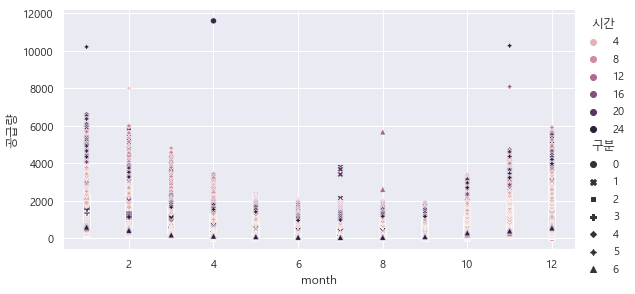

In [35]:
sns.relplot(
    data=total, x='month', y='공급량', 
    hue='시간', style='구분', 
    height=4, aspect=2, 
)

In [36]:
total.columns

Index(['연월일', '시간', '구분', '공급량', 'temp_pca', 'year', 'month', 'day',
       'weekday'],
      dtype='object')

# train_val split

In [37]:
total['year'].value_counts()

2016    61488
2013    61320
2014    61320
2015    61320
2017    61320
2018    61320
Name: year, dtype: int64

In [38]:
train_years = [2013, 2014, 2015, 2016, 2017]
val_years   = [2018]

train = total[total['year'].isin(train_years)]
val   = total[total['year'].isin(val_years)]

In [39]:
features = ['구분', 'month', 'day', 'weekday', '시간', 'temp_pca']

train_x = train[features]
train_y = train['공급량']
val_x   = val[features]
val_y   = val['공급량']

# corr

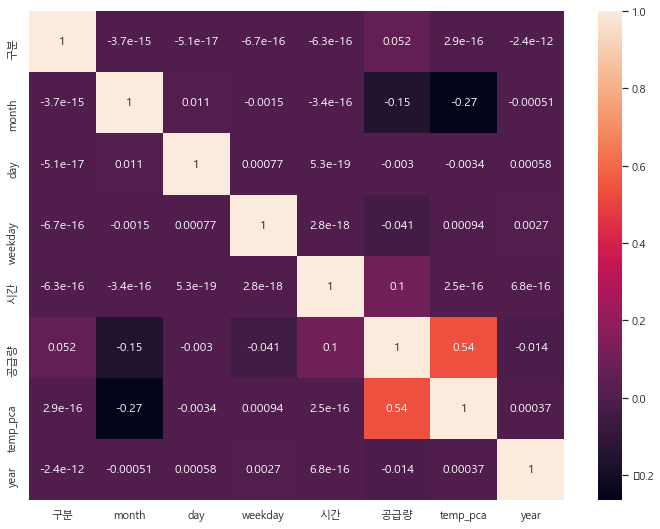

In [40]:
features = ['구분', 'month', 'day', 'weekday', '시간', '공급량', 'temp_pca', 'year']

plt.figure(figsize=(12, 9))
sns.heatmap(train[features].corr(), annot=True); plt.show()

# train

In [41]:
d_train = lgb.Dataset(train_x, train_y)
d_val   = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression', 
    'metric': 'mae', 
    'seed': 42
}

model = lgb.train(
    params, d_train, 500, d_val, 
    verbose_eval=20, early_stopping_rounds=10, 
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 6
[LightGBM] [Info] Start training from score 934.864036
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 220.494
[40]	valid_0's l1: 165.388
[60]	valid_0's l1: 154.534
[80]	valid_0's l1: 150.578
[100]	valid_0's l1: 149.335
[120]	valid_0's l1: 148.068
[140]	valid_0's l1: 147.169
Early stopping, best iteration is:
[136]	valid_0's l1: 147.14


# sub

In [42]:
features = ['구분', 'month', 'day', 'weekday', '시간', 'temp_pca']
test_x = test[features]

In [43]:
preds = model.predict(test_x)

In [45]:
preds

array([2108.06967602, 1888.26992328, 1817.06592031, ...,  410.82055336,
        354.80372751,  325.8210663 ])

In [47]:
sub['공급량'] = preds
sub

,일자|시간|구분,공급량
0,2019-01-01 01 A,2108.069676
1,2019-01-01 02 A,1888.269923
2,2019-01-01 03 A,1817.065920
3,2019-01-01 04 A,1836.989653
4,2019-01-01 05 A,1970.488097
...,...,...
15115,2019-03-31 20 H,428.737858
15116,2019-03-31 21 H,425.750718
15117,2019-03-31 22 H,410.820553
15118,2019-03-31 23 H,354.803728


In [48]:
# sub.to_csv('./sub/sub_00.csv', index=False)